In [1]:
using Revise
using QuantumClifford
using QuantumClifford.Experimental.NoisyCircuits
using AbstractAlgebra
using Plots
using LaTeXStrings
using Quantikz: displaycircuit

# States of interest

All of the states will be expressed in one of the many canonical forms available, so that comparisons can be performed easily.

A typical Bell pair

In [2]:
good_bell_state = S"XX
                    ZZ"
canonicalize_rref!(good_bell_state)[1]

+ ZZ
+ XX

A typical GHZ state

In [3]:
good_ghz3_state = S"XXX
                    ZZI
                    IZZ"
canonicalize_rref!(good_ghz3_state)[1]

+ _ZZ
+ Z_Z
+ XXX

The bi-colored graph state version of a GHZ state

In [4]:
good_ghz3_state = S"ZXX
                    XZI
                    XIZ"
canonicalize_rref!(good_ghz3_state)[1]

+ _ZZ
+ ZXX
+ X_Z


# Warmup example: Purifying a Bell pair

We will first run a typical purification circuit on two perfect Bell pairs. Given that all gates and initial states are perfect, the circuit is redundant, but running this calculation is a good sanity check. After all, if the circuit is not preserving perfect Bell pairs, there is little chance it would be doing any purification either.

There are three components to the circuit: the bilateral CPHASE (or CNOT) gates, the coincidence measurement performed by Alice and Bob to check for errors, and a "verify" step at the end of the simulation. Experimentally, Alice and Bob do not have access to this operation, but we add it in our calculation in order to verify whether the final state obtained by this procedure is indeed the state we want.

In terms of library features, we use the `SparseGate` and `BellMeasurement` objects for the "real" part of the circuit and the `VerifyOp` for the verification step.

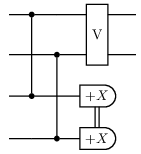

In [5]:
initial_state = good_bell_state⊗good_bell_state
circuit = [
    SparseGate(CPHASE, [1,3]),
    SparseGate(CPHASE, [2,4]),
    BellMeasurement([X,X], [3,4]),
    VerifyOp(good_bell_state, [1,2])
]
displaycircuit(circuit)

We can run a Monte Carlo simulation with `mctrajectories`, or a Perturbative Expansion calculation with `petrajectories`. Given that there is no noise source in this circuit, all Monte Carlo samples will give the same result.

In [6]:
petrajectories(initial_state, circuit)

Dict{Symbol, Float64} with 3 entries:
  :undetected_failure => 0.0
  :detected_failure   => 0.0
  :true_success       => 1.0

In [7]:
mctrajectories(initial_state, circuit, trajectories=100)

Dict{Symbol, Int64} with 4 entries:
  :undetected_failure => 0
  :continue           => 0
  :detected_failure   => 0
  :true_success       => 100

The possible final statuses (`:undetected_failure`, `:detected_failure`, `:true_success`) come from the definitions of the various circuit operations. `SparseGate` always generates `:continue`, which tells the simulator to continue to the next operation. `BellMeasurement` can report `:detected_failure` or `:continue`, depending whether there was an anti-coincidence or a coincidence. Finally `VerifyOp` reports either `:true_success` if we indeed obtained the desired state, or a `:undetected_failure` if the obtained state is not the desired one even though the measurement step had reported `:continue`. Custom statuses can be implemented as well, as seen later on.

Later on we will also need to compare these results against no purification so we define this circuit for convenience:

In [8]:
nopurification_circuit = [VerifyOp(good_bell_state, [1,2])];

## Define a network noise parameter to be used for the rest of the notebook

For a more interesting calculation, we will now introduce network noise with the `NoiseOpAll` operation, which causes depolarization of certain strength to all of the qubits.

In [9]:
netnoise_value = 0.10
one_third_netnoise = netnoise_value/3 # The probability for X, Y, or Z error
netnoise = UnbiasedUncorrelatedNoise(one_third_netnoise)
netnoise_opall = NoiseOpAll(netnoise);

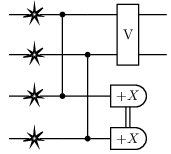

In [10]:
displaycircuit([netnoise_opall,circuit...]) # The explosions denote depolarization noise

In [11]:
pe_netnoise = petrajectories(initial_state, [netnoise_opall,circuit...])

Dict{Symbol, Float64} with 3 entries:
  :undetected_failure => 0.0972
  :detected_failure   => 0.1944
  :true_success       => 0.6561

In [12]:
pe_netnoise_nopurification = petrajectories(good_bell_state,
                                            [netnoise_opall,nopurification_circuit...],max_order=2)

Dict{Symbol, Float64} with 3 entries:
  :undetected_failure => 0.186667
  :detected_failure   => 0.0
  :true_success       => 0.813333

In [13]:
latexstring("""
    Therefore a network depolarization rate of $(3*one_third_netnoise)
    causes the fidelity to drop to
    \$F_{0}=
    $(round(pe_netnoise_nopurification[:true_success],digits=3))
    \$.
    """)

L"Therefore a network depolarization rate of 0.1
causes the fidelity to drop to
$F_{0}=
0.813
$.
"

In [14]:
latexstring("""
    But purification can increase the fidelity to
    \$\\frac{\\mathrm{true\\ success}}{\\mathrm{true\\ success}+\\mathrm{undetected\\ failure}}=
    $(round(pe_netnoise[:true_success] / (pe_netnoise[:true_success]+pe_netnoise[:undetected_failure]),digits=3))
    \$.
    """)

L"But purification can increase the fidelity to
$\frac{\mathrm{true\ success}}{\mathrm{true\ success}+\mathrm{undetected\ failure}}=
0.871
$.
"

In [15]:
latexstring("""
    With a rate of positive coincidence measurements of
    \$\\mathrm{true\\ success}+\\mathrm{undetected\\ failure}=
    $(round(pe_netnoise[:true_success]+pe_netnoise[:undetected_failure],digits=3))
    \$.
    """)

L"With a rate of positive coincidence measurements of
$\mathrm{true\ success}+\mathrm{undetected\ failure}=
0.753
$.
"

### Monte Carlo instead of Perturbative Expansions

The 10% network error rate we have picked is not all that small, and the perturbative expansion will not be all that accurate. We can attempt Monte Carlo simulations. For very large circuits this would be cheaper than perturbative expansions. Choosing the best method is a balancing act that depends on the desired accuracy, the size of the circuit, and the number of noisy components.

In [16]:
mc_netnoise = mctrajectories(initial_state, [netnoise_opall,circuit...],
                             trajectories=10000)

Dict{Symbol, Int64} with 4 entries:
  :undetected_failure => 1162
  :continue           => 0
  :detected_failure   => 2176
  :true_success       => 6662

### Symbolic Perturbative Expansions

The perturbative expansions can be done with any of the available symbolic libraries under Julia (including the Julia interface to the SymPy Python library). Here we give an example with `AbstractAlgebra.jl`, part of Nemo. Fractions are a bit clunky, so we treat the numerator and denominator separately. `SymPy` would be simpler to use, but it can be a bit slower.

We will define two symbols, one for the network noise, and one for the gate noise to be used later.

In [17]:
using AbstractAlgebra
R, (e_netn, e_gate) = PolynomialRing(RealField, ["e_n", "e_g"])
sym_unity = R(1);

In [18]:
sym_netnoise = UnbiasedUncorrelatedNoise(1//3*e_netn)
sym_netnoise_opall = NoiseOpAll(sym_netnoise);

In [19]:
sym_pe_netnoise = petrajectories(initial_state, [sym_netnoise_opall,circuit...],
                             branch_weight=sym_unity)

sym_true_success = sym_pe_netnoise[:true_success]
sym_coincidence_prob = (sym_pe_netnoise[:true_success]+sym_pe_netnoise[:undetected_failure]);

We can print out the symbolic expression:

In [20]:
latexstring(sym_true_success)

L"$1.0*e_n^4 + -4.0*e_n^3 + 6.0*e_n^2 + -4.0*e_n + 1.0$"

And evaluate it to compare it with the numerical calculation:

In [21]:
sym_true_success(netnoise_value, 0) # evaluate at e_n = netnoise_value, e_g = 0

0.65609999999999998854770255629631492411135695874691009521484375

In [22]:
pe_netnoise[:true_success]

0.6561000000000001

### Higher order expansions

Higher order expansions are also possible with this library, however the cost of the simulation grows exponentially in the order, due to the combinatorial explosion of trajectories that need to be followed. See the example below where we see the number of branches for the depolarization acting on all qubits.

In [23]:
for order in [0,1,2,3,4]
    branches = applynoise_branches(initial_state, netnoise, [1,2,3,4], max_order=order)
    println((order = order, nb_of_branches = length(branches), total_probability = sum(b[2] for b in branches)))
end

(order = 0, nb_of_branches = 1, total_probability = 0.6561000000000001)
(order = 1, nb_of_branches = 13, total_probability = 0.9477)
(order = 2, nb_of_branches = 67, total_probability = 0.9963000000000006)
(order = 3, nb_of_branches = 175, total_probability = 0.9999000000000002)
(order = 4, nb_of_branches = 256, total_probability = 1.0000000000000009)


Let us compute the whole circuits to the given order

In [24]:
@time sym_pe_netnoise2 = petrajectories(initial_state, [sym_netnoise_opall,circuit...],
                                  branch_weight=sym_unity, max_order=2);
@time sym_pe_netnoise3 = petrajectories(initial_state, [sym_netnoise_opall,circuit...],
                                  branch_weight=sym_unity, max_order=3);
@time sym_pe_netnoise4 = petrajectories(initial_state, [sym_netnoise_opall,circuit...],
                                  branch_weight=sym_unity, max_order=4);

  0.017603 seconds (47.59 k allocations: 2.694 MiB, 76.93% compilation time)
  0.007931 seconds (97.47 k allocations: 5.261 MiB)
  0.011633 seconds (141.62 k allocations: 7.579 MiB)


### All of the results together

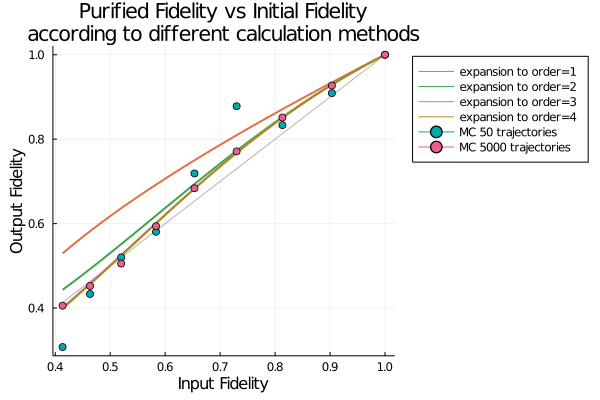

In [25]:
plot(title="Purified Fidelity vs Initial Fidelity\naccording to different calculation methods")

netnoise_pe_samples = 0.0:0.005:0.4
netnoise_mc_samples = 0.0:0.05:0.4
mc_trajectories = [50, 5000]

# No purification
exact_solution_no_purification = petrajectories(good_bell_state,
                                                [sym_netnoise_opall,nopurification_circuit...],
                                                branch_weight=sym_unity,
                                                max_order=100)
F0 = exact_solution_no_purification[:true_success].(netnoise_pe_samples,0)
plot!(F0,F0,color=:black,alpha=0.3,label=false)

# Symbolic perturbative expansions
for (order,sym_result) in enumerate(
        [sym_pe_netnoise,sym_pe_netnoise2,sym_pe_netnoise3,sym_pe_netnoise4])
    ts = sym_result[:true_success].(netnoise_pe_samples, 0)
    uf = sym_result[:undetected_failure].(netnoise_pe_samples, 0)
    Fout = ts ./ (ts .+ uf)
    plot!(F0, Fout, label="expansion to order=$(order)", lw=2)
end

# Monte Carlo approach
F0 = exact_solution_no_purification[:true_success].(netnoise_mc_samples,0)
for m in mc_trajectories
    Fout_mc = []
    for n in netnoise_mc_samples
        one_third_netnoise = n/3 # The probability for X, Y, or Z error
        netnoise = UnbiasedUncorrelatedNoise(one_third_netnoise)
        netnoise_opall = NoiseOpAll(netnoise)
        mc_netnoise = mctrajectories(initial_state, [netnoise_opall,circuit...],
                                     trajectories=m)
        push!(Fout_mc, mc_netnoise[:true_success]/(mc_netnoise[:true_success]+mc_netnoise[:undetected_failure]))
    end
    plot!(F0, Fout_mc, label="MC $(m) trajectories", line=false, marker=true)
end      

plot!(legend=:outertopright, xlabel="Input Fidelity", ylabel="Output Fidelity")